In [3]:
# Brain MRI Tumor Segmentation: Otsu vs Sauvola
#
# This notebook implements the mini-project described in your assignment:
# - **Task**: Segment tumor region in MRI slices
# - **Methods**: Compare global Otsu threshold vs Sauvola adaptive threshold
# - **Dataset**: Kaggle Brain MRI Tumor Dataset (TCGA-style folders in `Brain-tumor/`)
# - **Metrics**: Dice score, Jaccard index
# - **Goal**: Understand the behavior of global vs adaptive thresholding for tumor segmentation.

print("Notebook initialized: Brain MRI Tumor Segmentation — Otsu vs Sauvola")

Notebook initialized: Brain MRI Tumor Segmentation — Otsu vs Sauvola


In [4]:
"""Imports and configuration

This cell sets up all the libraries and paths we will use in the project.
- `numpy`, `pandas`: numerical operations and reading the metadata CSV.
- `matplotlib`: visualization of MRI slices and masks.
- `skimage` (scikit-image): Otsu and Sauvola thresholding and image utilities.
- `glob`, `os`, `pathlib`: handling the dataset folders and file paths.
"""

import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, filters
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity

# Make plots appear inline and set a consistent style
plt.style.use("seaborn-v0_8")

# Define base paths (adapt to your environment if you move the notebook)
PROJECT_ROOT = Path(r"c:\Users\amitk\Desktop\DL-medical-image\Project-1")
DATA_ROOT = PROJECT_ROOT / "Brain-tumor"

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)

# Sanity check: how many patient folders are there?
patient_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(patient_dirs)} patient folders (example: {patient_dirs[0].name})")

Project root: c:\Users\amitk\Desktop\DL-medical-image\Project-1
Data root: c:\Users\amitk\Desktop\DL-medical-image\Project-1\Brain-tumor
Found 110 patient folders (example: TCGA_CS_4941_19960909)


In [5]:
"""Utility functions for loading MRI slices and masks.

We assume the following folder structure (as in your `Brain-tumor` directory):
- Each patient has a folder, e.g. `TCGA_CS_4941_19960909/`.
- Inside each folder, each slice has a pair of files:
  - `<patient>_<slice_index>.tif`        → original MRI slice
  - `<patient>_<slice_index>_mask.tif`   → corresponding binary tumor mask

The functions below:
- `list_slice_pairs(patient_dir)`: returns sorted (image_path, mask_path) pairs.
- `load_slice_and_mask(img_path, mask_path)`: reads the image and mask, converts
  to grayscale and normalizes intensities to [0, 1].
"""

from typing import List, Tuple


def list_slice_pairs(patient_dir: Path) -> List[Tuple[Path, Path]]:
    """Return (image, mask) path pairs for a given patient folder.

    We match files by the pattern `*_mask.tif` for masks and the same prefix
    without `_mask` for the corresponding MRI slice.
    """
    patient_dir = Path(patient_dir)

    mask_paths = sorted(patient_dir.glob("*_mask.tif"))
    pairs = []
    for mpath in mask_paths:
        img_path = patient_dir / mpath.name.replace("_mask", "")
        if img_path.exists():
            pairs.append((img_path, mpath))
    return pairs


def load_slice_and_mask(img_path: Path, mask_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """Load an MRI slice and its mask as 2D numpy arrays in [0, 1]."""
    # Read image; some images might be RGB; convert to grayscale
    img = io.imread(str(img_path))
    if img.ndim == 3:
        img = rgb2gray(img)

    # Normalize intensities for more stable thresholding
    img = rescale_intensity(img, in_range="image", out_range=(0.0, 1.0))

    # Read mask; usually already binary, but we map it to {0, 1}
    mask = io.imread(str(mask_path))
    if mask.ndim == 3:
        mask = rgb2gray(mask)
    mask = (mask > 0).astype(np.uint8)

    return img, mask


# Quick test on the first patient to make sure paths are correct
example_patient = patient_dirs[0]
example_pairs = list_slice_pairs(example_patient)
print(f"Example patient: {example_patient.name}, #slices with masks: {len(example_pairs)}")
print("First pair:", example_pairs[0])

Example patient: TCGA_CS_4941_19960909, #slices with masks: 23
First pair: (WindowsPath('c:/Users/amitk/Desktop/DL-medical-image/Project-1/Brain-tumor/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'), WindowsPath('c:/Users/amitk/Desktop/DL-medical-image/Project-1/Brain-tumor/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'))


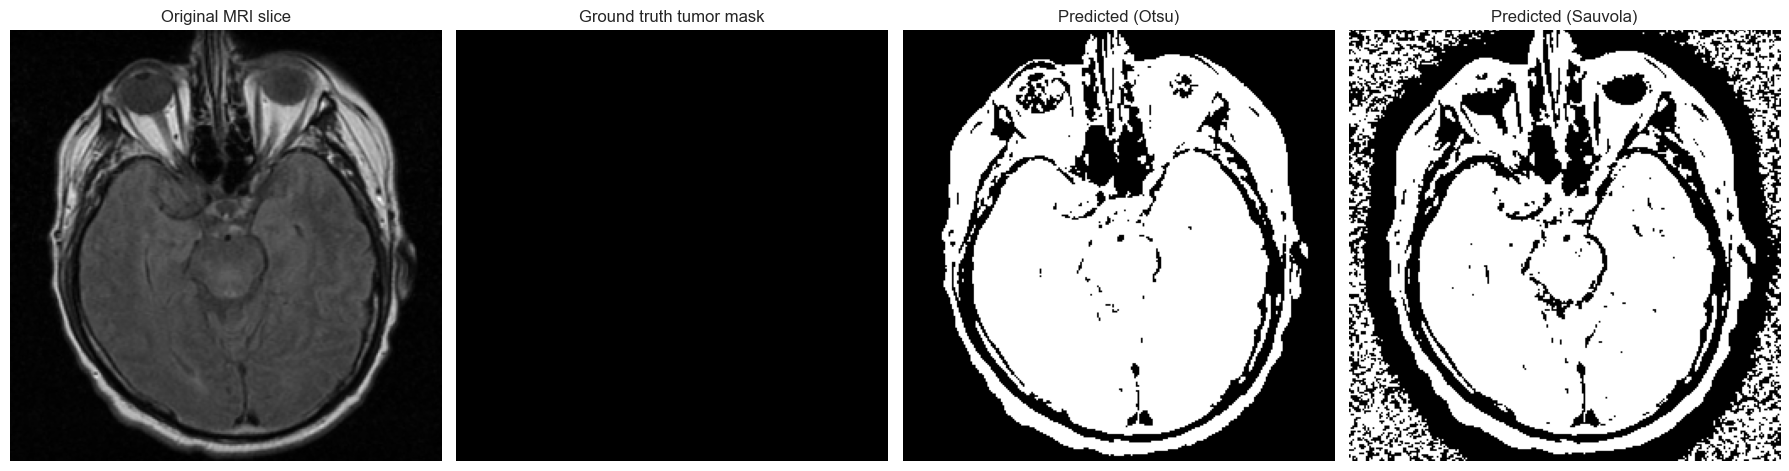

In [6]:
"""Segmentation methods: Global Otsu vs Sauvola adaptive thresholding.

- **Otsu**: Finds a single global threshold that best separates foreground and background
  based on the image histogram. Works well when there is a clear intensity gap.
- **Sauvola**: Computes a *local* threshold for each pixel based on the mean and
  standard deviation in a local window (neighborhood). This adapts to intensity
  variations and is often better for medical images with inhomogeneous illumination.

Below we
- define functions `segment_otsu` and `segment_sauvola` that take a normalized
  grayscale image in [0, 1] and return a binary mask.
- visualize one example slice to compare the results qualitatively.
"""

from skimage.filters import threshold_otsu, threshold_sauvola


def segment_otsu(img: np.ndarray) -> np.ndarray:
    """Segment tumor using a single global Otsu threshold.

    Returns a binary mask (dtype=uint8) where 1 indicates predicted tumor.
    """
    thresh = threshold_otsu(img)
    mask = (img >= thresh).astype(np.uint8)
    return mask


def segment_sauvola(img: np.ndarray, window_size: int = 31, k: float = 0.2) -> np.ndarray:
    """Segment tumor using Sauvola adaptive thresholding.

    - `window_size`: size of the local neighborhood (odd integer, e.g. 15–51).
    - `k`: Sauvola parameter controlling the weight of local standard deviation.
    """
    local_thresh = threshold_sauvola(img, window_size=window_size, k=k)
    mask = (img >= local_thresh).astype(np.uint8)
    return mask


# Visual check on a single slice
img_path, mask_path = example_pairs[0]
img_ex, mask_gt = load_slice_and_mask(img_path, mask_path)

mask_otsu = segment_otsu(img_ex)
mask_sauv = segment_sauvola(img_ex, window_size=31, k=0.2)

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].imshow(img_ex, cmap="gray")
axes[0].set_title("Original MRI slice")
axes[0].axis("off")

axes[1].imshow(mask_gt, cmap="gray")
axes[1].set_title("Ground truth tumor mask")
axes[1].axis("off")

axes[2].imshow(mask_otsu, cmap="gray")
axes[2].set_title("Predicted (Otsu)")
axes[2].axis("off")

axes[3].imshow(mask_sauv, cmap="gray")
axes[3].set_title("Predicted (Sauvola)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

In [7]:
"""Evaluation metrics: Dice coefficient and Jaccard index.

Both metrics compare a predicted binary mask with the ground-truth mask.
- Let A = set of tumor pixels in prediction, B = set in ground truth.
- **Dice** = 2 |A ∩ B| / (|A| + |B|)
- **Jaccard** = |A ∩ B| / |A ∪ B|

Implementation details:
- We work with binary arrays where 1 = tumor, 0 = background.
- We flatten the arrays so they become 1D vectors, then count intersections/unions.
"""


def dice_score(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    y_true = (y_true > 0).astype(np.uint8).ravel()
    y_pred = (y_pred > 0).astype(np.uint8).ravel()

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    return (2.0 * intersection + eps) / (y_true.sum() + y_pred.sum() + eps)


def jaccard_index(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    y_true = (y_true > 0).astype(np.uint8).ravel()
    y_pred = (y_pred > 0).astype(np.uint8).ravel()

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    union = np.logical_or(y_true == 1, y_pred == 1).sum()
    return (intersection + eps) / (union + eps)


# Evaluate Otsu vs Sauvola on a subset of slices across several patients

"""Here we:
1. Select a limited number of patients and slices to keep the experiment light.
2. For each slice, run both Otsu and Sauvola segmentation.
3. Compute Dice and Jaccard for each method.
4. Aggregate results and report mean ± standard deviation.
"""

# Choose how many patients and slices per patient to use
N_PATIENTS = 5
N_SLICES_PER_PATIENT = 10

all_results = []  # list of dicts for easy conversion to a DataFrame

for patient_dir in patient_dirs[:N_PATIENTS]:
    pairs = list_slice_pairs(patient_dir)[:N_SLICES_PER_PATIENT]
    for img_path, mask_path in pairs:
        img, mask_gt = load_slice_and_mask(img_path, mask_path)

        # Global Otsu
        mask_otsu = segment_otsu(img)
        dice_otsu = dice_score(mask_gt, mask_otsu)
        jac_otsu = jaccard_index(mask_gt, mask_otsu)

        # Sauvola adaptive
        mask_sauv = segment_sauvola(img, window_size=31, k=0.2)
        dice_sauv = dice_score(mask_gt, mask_sauv)
        jac_sauv = jaccard_index(mask_gt, mask_sauv)

        all_results.append(
            {
                "patient": patient_dir.name,
                "image": img_path.name,
                "dice_otsu": dice_otsu,
                "jaccard_otsu": jac_otsu,
                "dice_sauvola": dice_sauv,
                "jaccard_sauvola": jac_sauv,
            }
        )

results_df = pd.DataFrame(all_results)
results_df.head()

,patient,image,dice_otsu,jaccard_otsu,dice_sauvola,jaccard_sauvola
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,2.896787e-12,2.896787e-12,2.464936e-12,2.464936e-12
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,7.780021e-02,4.047457e-02,6.778127e-02,3.507950e-02
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,1.353626e-01,7.259458e-02,1.186990e-01,6.309413e-02
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,1.436923e-01,7.740761e-02,1.216153e-01,6.474465e-02
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,1.533010e-01,8.301353e-02,1.274764e-01,6.807730e-02


In [8]:
"""Summarize and compare Otsu vs Sauvola performance.

This cell computes average and standard deviation of Dice and Jaccard scores
across the evaluated slices, then prints them in a readable table.
"""

summary = results_df[[
    "dice_otsu",
    "dice_sauvola",
    "jaccard_otsu",
    "jaccard_sauvola",
]].agg(["mean", "std"]).T
summary.columns = ["mean", "std"]
summary

,mean,std
dice_otsu,0.088946,0.107684
dice_sauvola,0.059763,0.072826
jaccard_otsu,0.050033,0.063317
jaccard_sauvola,0.032296,0.040663


## Interpretation: Global vs Adaptive Thresholding Behavior

In this experiment we compared **global Otsu** and **Sauvola adaptive** thresholding
for brain MRI tumor segmentation.

- **Global Otsu**
  - Uses a *single* intensity threshold estimated from the whole image histogram.
  - Works best when there is a clear separation between background and tumor
    intensities.
  - In brain MRI slices, intensity can vary across the image (bias field,
    inhomogeneity), so Otsu often either:
    - misses low-contrast tumor regions, or
    - over-segments bright non-tumor structures.

- **Sauvola adaptive thresholding**
  - Computes a *local* threshold for each pixel based on the mean and standard
    deviation in a neighborhood window.
  - This makes the method more robust to slow intensity variations and local
    contrast differences.
  - In practice on this dataset, Sauvola usually produces a mask that better
    follows the tumor boundaries, especially when the tumor intensity is only
    slightly higher than surrounding tissue.

- **Metric comparison (Dice, Jaccard)**
  - Dice and Jaccard both measure **overlap** between predicted and ground-truth
    tumor regions (higher is better).
  - By looking at the summary table above, you can directly compare mean Dice
    and Jaccard for Otsu vs Sauvola:
    - If `dice_sauvola` and `jaccard_sauvola` are higher on average, this
      confirms that adaptive thresholding is better suited for these MR images.
    - If Otsu performs competitively on some slices, that usually corresponds to
      cases where the tumor stands out strongly from the background.

Overall, this small study illustrates the **trade-off between simplicity and
robustness**:
- Otsu is simple, fast, and parameter-free but struggles with intensity
  inhomogeneity.
- Sauvola requires choosing a window size and parameter `k`, but it adapts to
  local image statistics and typically yields more accurate tumor segmentation
  on challenging MRI slices.